In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_40892\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [3]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - prvi krajec

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med prvim krajcem, razlikuje od ritmičnosti ostalih nesreč.

In [4]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'First Quarter')

accidents_first_quarter = accidents_moon[moon_mask]
# display(accidents_first_quarter)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_first_quarter['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsFirstQ",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

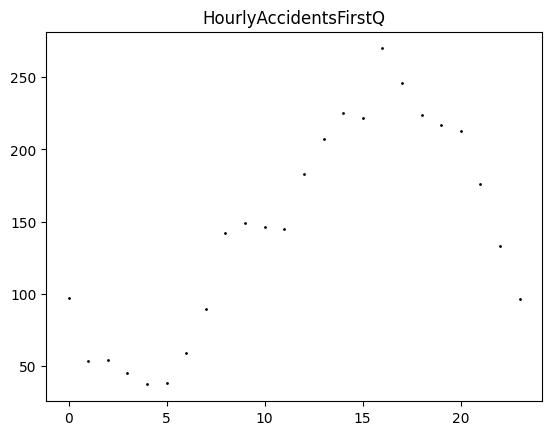

In [5]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsFirstQ"])

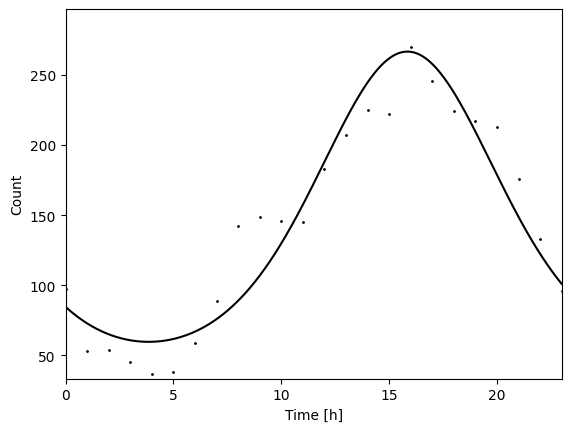

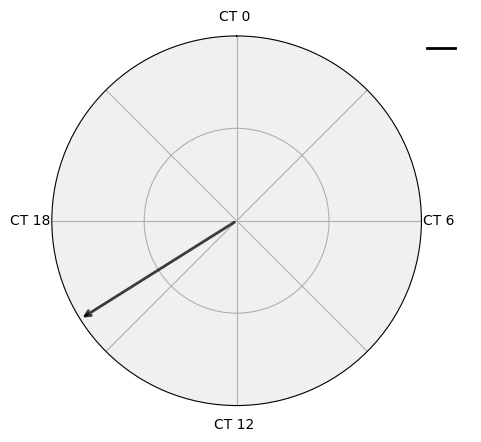

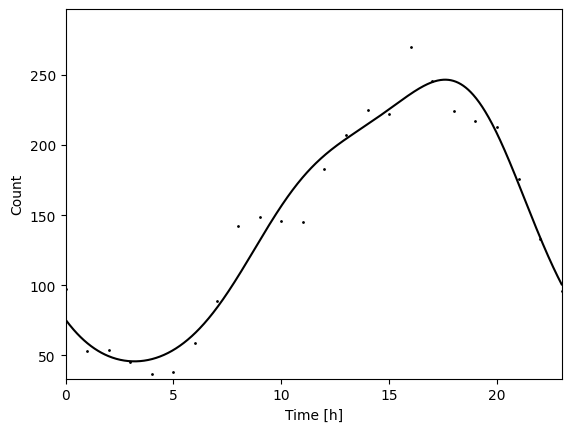

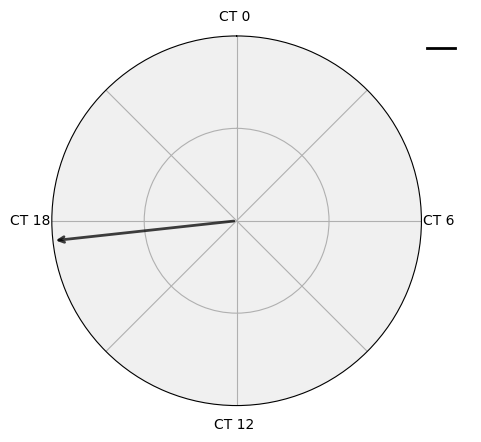

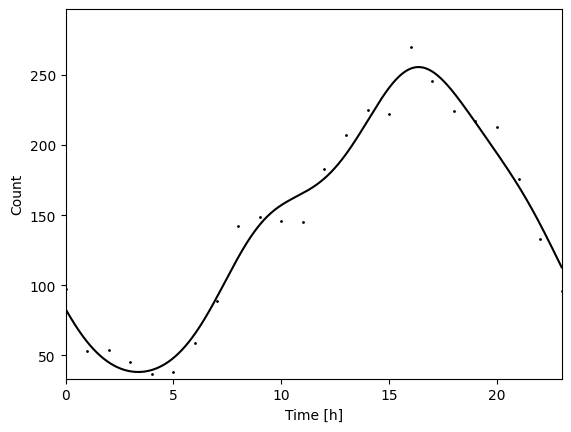

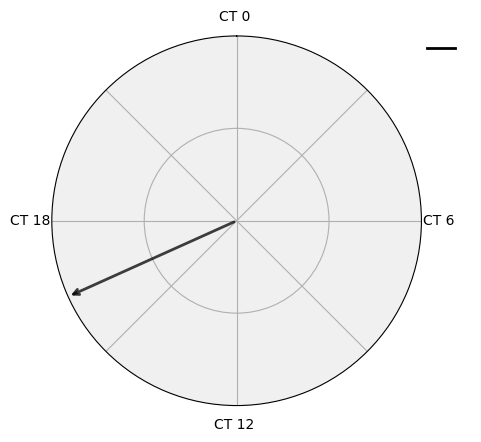

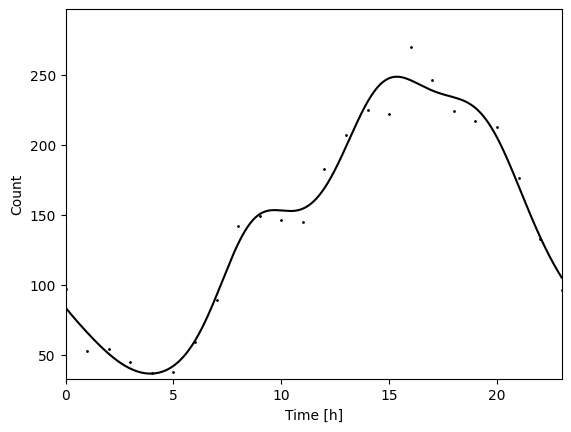

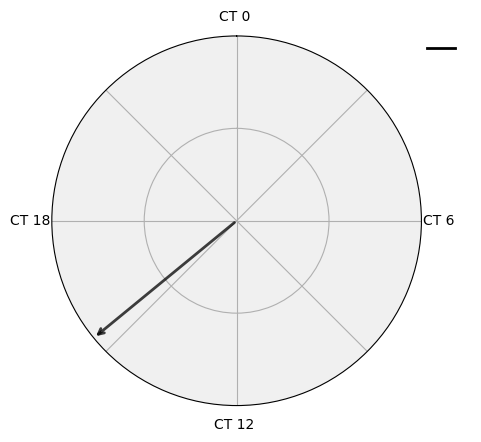

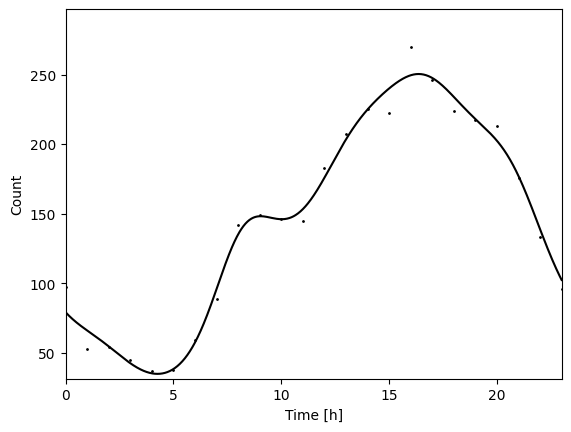

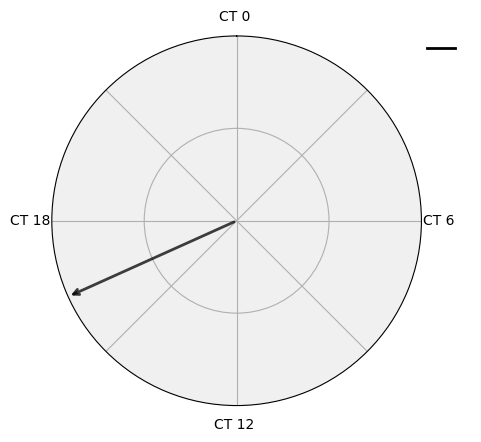

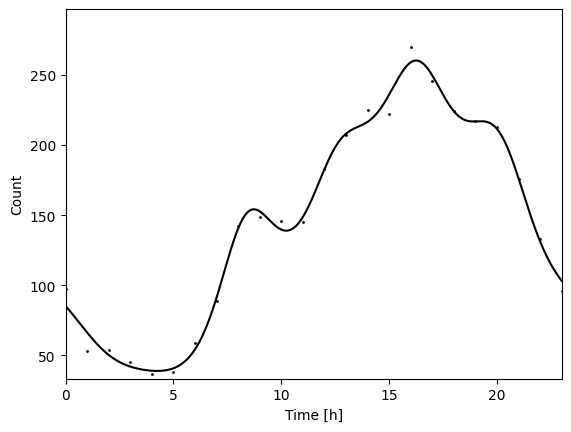

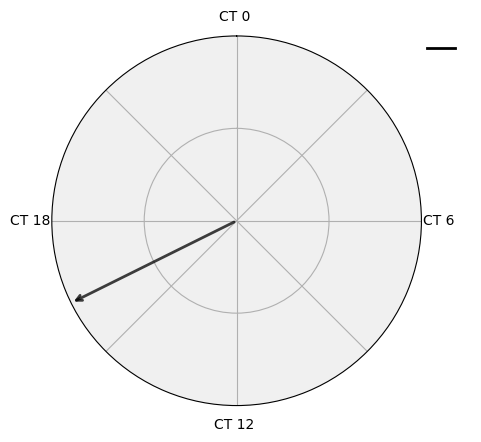

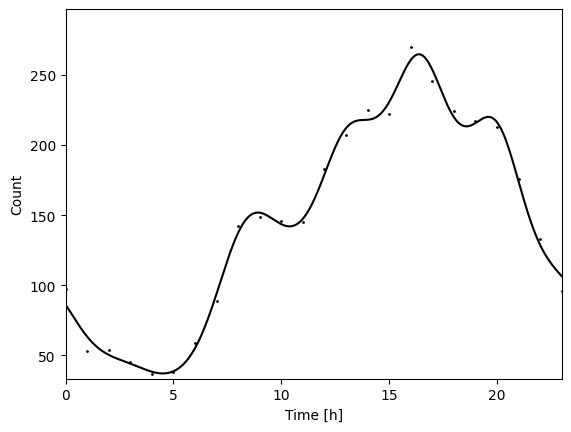

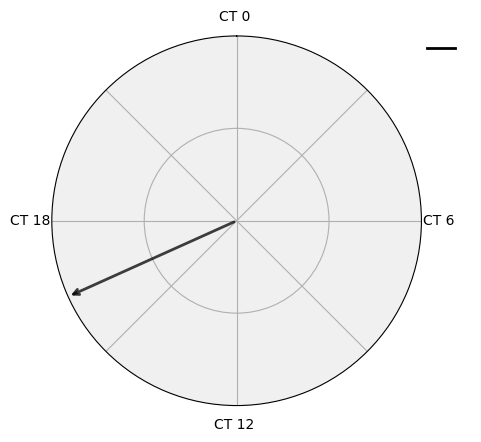

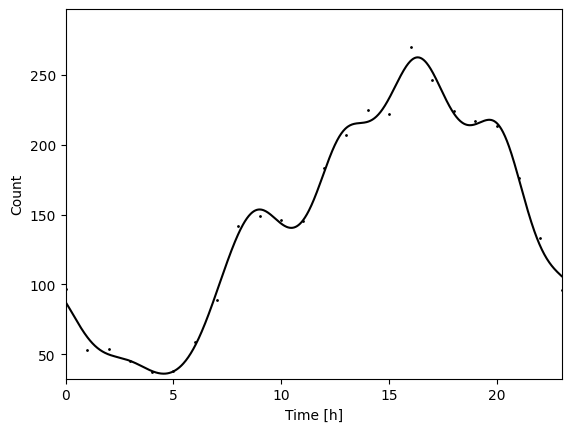

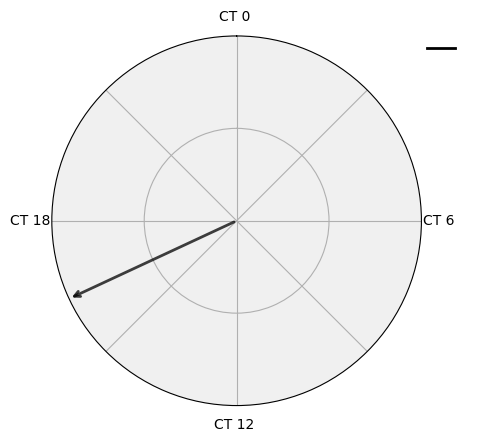

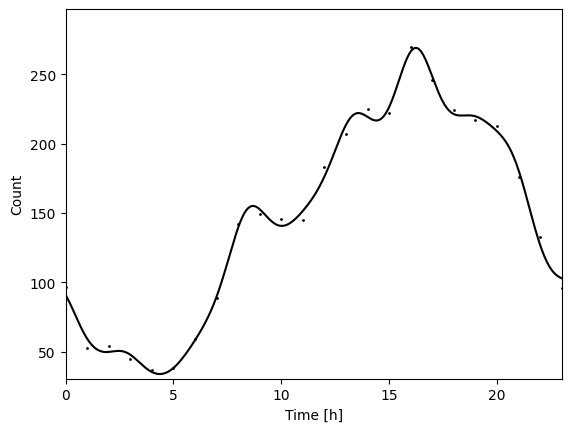

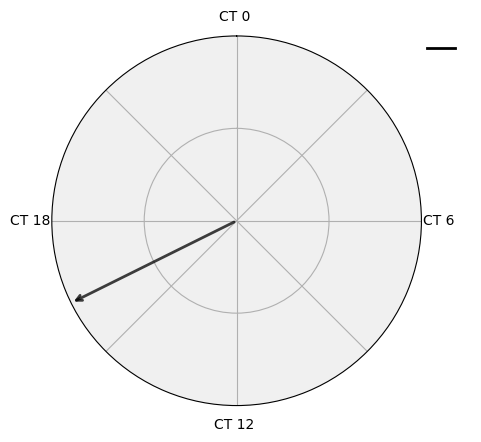

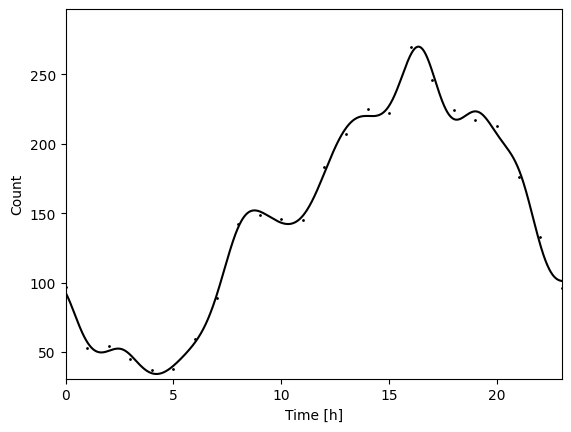

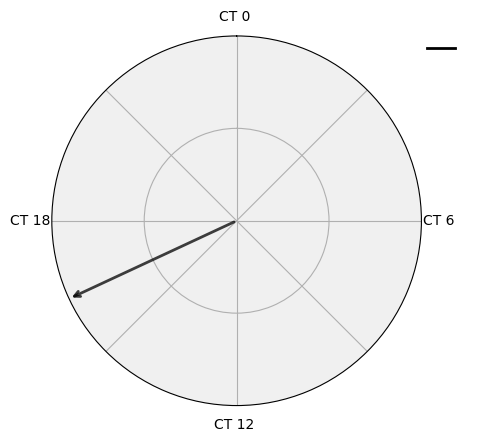

In [6]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsFirstQ', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [7]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFirstQ,24.0,1.0,3.041127e-13,3.041127e-13,11801.217933,-108.977586,0.209155,103.536537,2.132132,163.159039,[15.855855855855856],[266.6955761318432],[3.843843843843844],[59.62250185692028]
1,HourlyAccidentsFirstQ,24.0,2.0,5.646947e-16,6.274385e-16,5810.167509,-99.005003,0.281526,100.483623,1.679290,146.176349,[17.585585585585587],[246.6599125634087],[3.171171171171171],[45.69380060011807]
2,HourlyAccidentsFirstQ,24.0,3.0,3.742491e-17,4.678114e-17,3477.417571,-93.019781,0.324960,108.776288,1.993764,146.885564,[16.384384384384383],[255.65835944178923],[3.3633633633633635],[38.109275344017284]
3,HourlyAccidentsFirstQ,24.0,4.0,3.801178e-18,5.430255e-18,2643.562685,-87.675617,0.363743,106.080969,2.257921,142.623607,"[9.657657657657657, 15.375375375375375]","[153.37446744345127, 248.70171358143853]",[3.93993993993994],[36.542638073950506]
4,HourlyAccidentsFirstQ,24.0,5.0,2.726334e-18,4.543890e-18,1765.181616,-84.557580,0.386370,107.732821,1.993764,142.642063,"[9.033033033033034, 16.384384384384383]","[148.18638202703457, 250.37277682147115]",[4.276276276276276],[34.91084516133004]
5,HourlyAccidentsFirstQ,24.0,6.0,1.619390e-19,5.397965e-19,905.095985,-78.848959,0.427797,110.746902,2.031500,149.604599,"[8.744744744744745, 16.24024024024024, 19.2672...","[154.17675668249709, 260.35138050435086, 217.0...","[4.228228228228228, 10.234234234234235]","[38.858281072262244, 138.91903403653842]"
6,HourlyAccidentsFirstQ,24.0,7.0,2.257681e-19,5.644202e-19,794.961648,-76.663481,0.443657,113.865790,1.993764,150.922912,"[8.936936936936936, 16.384384384384383, 19.603...","[151.85823481178545, 264.7887015366063, 220.11...","[4.516516516516517, 10.378378378378379]","[37.057122194521696, 142.00836327349137]"
7,HourlyAccidentsFirstQ,24.0,8.0,1.203300e-18,2.406600e-18,810.975100,-76.087188,0.447839,113.203729,2.006342,149.277373,"[8.984984984984985, 16.336336336336338, 19.651...","[153.60383951921676, 262.4797717959284, 217.79...","[4.564564564564565, 10.474474474474475]","[36.07543740726748, 140.43400256802755]"
8,HourlyAccidentsFirstQ,24.0,9.0,6.681349e-20,3.340675e-19,495.794584,-70.447531,0.488766,117.552892,2.031500,151.505170,"[8.696696696696696, 13.597597597597597, 16.240...","[155.0986731340601, 222.0662569708304, 269.058...","[1.8738738738738738, 4.372372372372372, 10.042...","[49.787563081617286, 33.95227774475915, 140.73..."
9,HourlyAccidentsFirstQ,24.0,10.0,6.569876e-20,3.340675e-19,466.104897,-68.097720,0.505818,117.923116,2.006342,152.037273,"[13.933933933933934, 16.336336336336338, 18.97...","[220.02518762455955, 269.93763165820604, 223.3...","[1.6336336336336337, 4.228228228228228, 10.330...","[49.639526701598946, 34.11744512338152, 142.15..."


### Katero je najboljše število komponent

In [8]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFirstQ,24.0,6.0,1.619390e-19,5.397965e-19,905.095985,-78.848959,0.427797,110.746902,2.0315,149.604599,"[8.744744744744745, 16.24024024024024, 19.2672...","[154.17675668249709, 260.35138050435086, 217.0...","[4.228228228228228, 10.234234234234235]","[38.858281072262244, 138.91903403653842]"


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


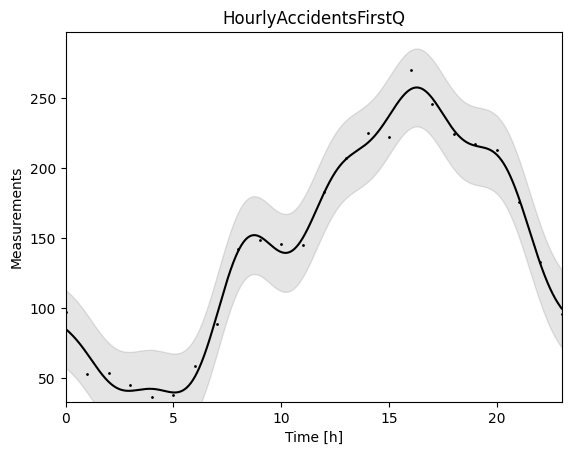

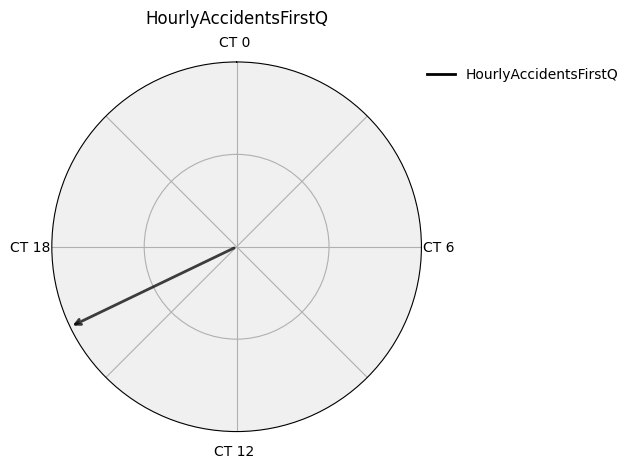

In [9]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsFirstQ",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

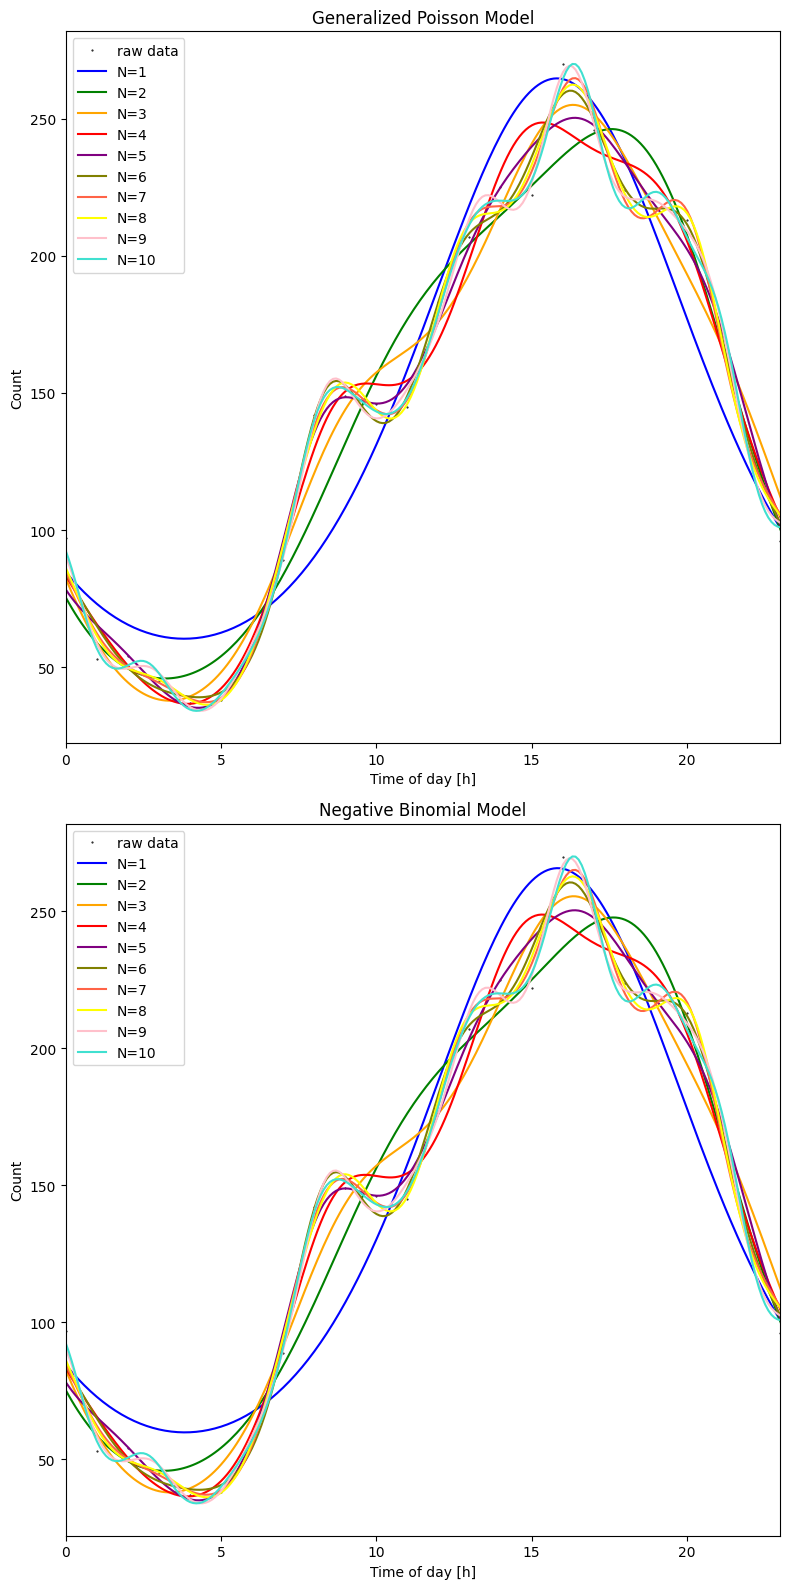

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,102.13,162.51,[15.82],[264.64],3.134319e-13,11636.006068,226.015541,230.727756,-109.007770,"[-4.1939044873575995, -4.2780754612179805, -3....",144.260733,"[84.72381467898352, 73.13278310878606, 65.5263...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.72381467898352, 83.3675492473207, 82.05644..."
1,gen_poisson,2,100.14,146.03,[17.62],[246.16],3.519664e-15,5778.892353,213.766373,220.834696,-100.883186,"[-5.755612897621134, -3.232512699749705, -3.15...",144.261126,"[75.50151760691924, 58.91362853250337, 49.5368...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[75.50151760691924, 73.472657514565, 71.529368..."
2,gen_poisson,3,108.59,146.39,[16.32],[254.99],5.945846e-17,3459.933616,203.007956,212.432387,-93.503978,"[-4.538507538586373, -3.2079269661238072, -3.9...",144.170986,"[82.48125117365949, 59.03805506285004, 44.4833...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[82.48125117365949, 79.76955857379113, 77.1308..."
3,gen_poisson,4,105.95,142.59,[15.32],[248.55],4.112578e-18,2641.219059,195.518531,207.299069,-87.759265,"[-4.406927159715764, -4.433337088060185, -2.93...",144.416667,"[83.40592701069279, 65.6979869901275, 50.61143...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[83.40592701069279, 81.50984395434868, 79.6471..."
4,gen_poisson,5,107.53,142.73,[16.42],[250.26],5.318066e-18,1765.306084,194.558501,208.695147,-85.279251,"[-5.6818203506282, -4.365761222406718, -2.8077...",144.416667,"[78.3742564270201, 65.41072569216229, 54.48011...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[78.3742564270201, 76.7362483953174, 75.200180..."
5,gen_poisson,6,110.56,149.60,"[16.22, 19.22]","[260.16, 217.22]",3.621823e-18,908.039602,192.495899,208.988653,-82.247950,"[-4.27889106524583, -4.297627754212371, -2.999...",144.416667,"[84.0460167246928, 65.11570699304329, 49.90713...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.0460167246928, 82.1876149996913, 80.310036..."
6,gen_poisson,7,113.74,150.99,"[16.42, 19.62]","[264.73, 220.33]",1.565592e-17,793.481107,194.750003,213.598865,-81.375002,"[-4.125555687687566, -3.7300268086119743, -2.9...",144.416667,"[84.86554125046402, 62.38370089092668, 50.1614...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.86554125046402, 82.44009330628711, 80.0031..."
7,gen_poisson,8,113.05,149.35,"[16.32, 19.62]","[262.39, 218.03]",1.079158e-16,813.417874,198.349267,219.554236,-81.174634,"[-3.880032806981646, -3.5772762166956866, -3.0...",144.416667,"[86.33241883032855, 61.53056467969578, 49.6510...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[86.33241883032855, 83.7774265456158, 81.15667..."
8,gen_poisson,9,117.55,151.69,"[13.61, 16.22, 18.62]","[222.07, 269.24, 220.67]",2.058005e-16,496.240095,199.265107,222.826183,-79.632553,"[-3.38301363443928, -3.172748982529164, -3.038...",144.416667,"[90.39984770792391, 58.79938705916221, 49.5441...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[90.39984770792391, 87.51481664994813, 84.3584..."
9,gen_poisson,10,117.91,151.99,"[13.91, 16.32, 19.02]","[220.08, 269.9, 223.29]",9.153951e-16,466.555621,202.338561,228.255745,-79.169280,"[-3.222753034648804, -2.971249629386911, -2.93...",144.416667,"[92.54612171746305, 56.88421092722368, 50.6686...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[92.54612171746305, 89.33595929207675, 85.7275..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


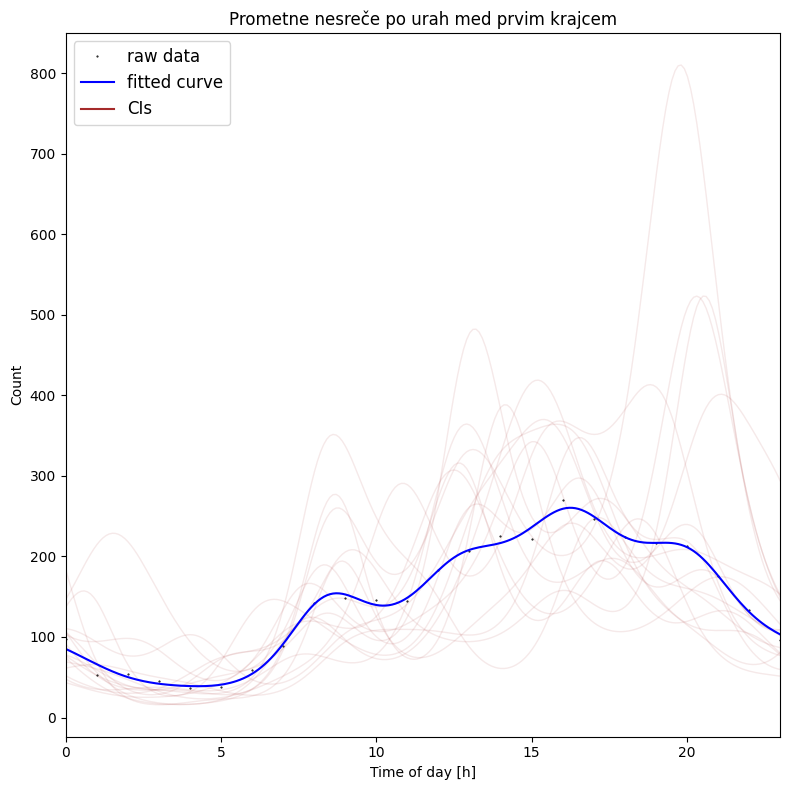

Intervali zaupanja:


,0,1
0,4.551956,5.041713
1,-1.053376,-0.381274
2,-0.832818,-0.106504
3,-0.693324,0.179259
4,-0.093214,0.167515
5,-0.302907,0.287045
6,-0.098994,0.409156
7,-0.048215,0.233809
8,-0.271032,0.234391
9,-0.141304,0.138686


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah med prvim krajcem', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,110.56
mesor,149.6
peaks,"[16.22, 19.22]"
heights,"[260.16, 217.22]"
amplitude_CIs,"[17.7, 273.5]"
mesor_CIs,"[51.25, 310.8]"
peaks_CIs,"[[15.01, 17.37], [18.71, 20.02]]"
heights_CIs,"[[55.67, 537.52], [138.27, 358.05]]"
